In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# For loading dataset
from datasets import load_dataset

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("Random seed set to 42 for reproducibility")

✅ All libraries imported successfully!
Random seed set to 42 for reproducibility


In [2]:
print("\n" + "="*70)
print("LOADING MEDICAL DATASET FOR CLUSTERING ANALYSIS")
print("="*70)

# Load dataset from Hugging Face
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

# Convert to pandas DataFrames
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Combine all data for clustering (unsupervised - uses all available data)
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\n✅ Dataset loaded successfully!")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Total combined: {len(all_df)} samples")

print("\nNote: For clustering, we use all data since it's unsupervised learning")
print("      (No labels are used during cluster formation)")


LOADING MEDICAL DATASET FOR CLUSTERING ANALYSIS


Repo card metadata block was not found. Setting CardData to empty.



✅ Dataset loaded successfully!
Training set: 1724 samples
Validation set: 370 samples
Test set: 370 samples
Total combined: 2464 samples

Note: For clustering, we use all data since it's unsupervised learning
      (No labels are used during cluster formation)


## Load Dataset
<!-- Purpose: Load the medical transcription dataset
We'll perform clustering without using the specialty labels -->

In [3]:
print("\n" + "="*70)
print("TEXT VECTORIZATION FOR CLUSTERING")
print("="*70)

# Configure TfidfVectorizer (same as classification task)
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=3000,          # Use fewer features for clustering efficiency
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='ascii'
)

print("\nVectorizer configuration:")
print("-"*70)
print(f"  max_features: {vectorizer.max_features}")
print(f"  ngram_range: {vectorizer.ngram_range}")
print(f"  stop_words: {vectorizer.stop_words}")

print("\nTransforming documents to TF-IDF vectors...")
print("This may take 1-2 minutes...\n")

# Transform all transcriptions to TF-IDF vectors
X_tfidf = vectorizer.fit_transform(all_df['transcription'])

print("✅ Vectorization complete!")
print(f"   Shape: {X_tfidf.shape}")
print(f"   {X_tfidf.shape[0]} documents")
print(f"   {X_tfidf.shape[1]} features (vocabulary)")
print(f"   Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100:.2f}%")


TEXT VECTORIZATION FOR CLUSTERING

Vectorizer configuration:
----------------------------------------------------------------------
  max_features: 3000
  ngram_range: (1, 2)
  stop_words: english

Transforming documents to TF-IDF vectors...
This may take 1-2 minutes...

✅ Vectorization complete!
   Shape: (2464, 3000)
   2464 documents
   3000 features (vocabulary)
   Sparsity: 94.47%


## Text Vectorization for Clustering
<!-- Purpose: Convert text documents to TF-IDF numerical vectors
Same preprocessing as used in classification, but applied to all data -->


DETERMINING OPTIMAL NUMBER OF CLUSTERS

Method 1: Elbow Method (Inertia)
----------------------------------------------------------------------
Testing k values from 2 to 20...
This may take 3-5 minutes...

Testing k=2... Inertia: 2249.55, Silhouette: 0.0247
Testing k=3... Inertia: 2213.79, Silhouette: 0.0281
Testing k=4... Inertia: 2183.87, Silhouette: 0.0310
Testing k=5... Inertia: 2160.53, Silhouette: 0.0329
Testing k=6... Inertia: 2134.68, Silhouette: 0.0342
Testing k=7... Inertia: 2120.58, Silhouette: 0.0377
Testing k=8... Inertia: 2108.09, Silhouette: 0.0331
Testing k=9... Inertia: 2091.47, Silhouette: 0.0385
Testing k=10... Inertia: 2080.81, Silhouette: 0.0406
Testing k=11... Inertia: 2062.88, Silhouette: 0.0381
Testing k=12... Inertia: 2051.76, Silhouette: 0.0409
Testing k=13... Inertia: 2038.43, Silhouette: 0.0425
Testing k=14... Inertia: 2025.90, Silhouette: 0.0398
Testing k=15... Inertia: 2014.24, Silhouette: 0.0453
Testing k=16... Inertia: 2007.20, Silhouette: 0.0496
Testi

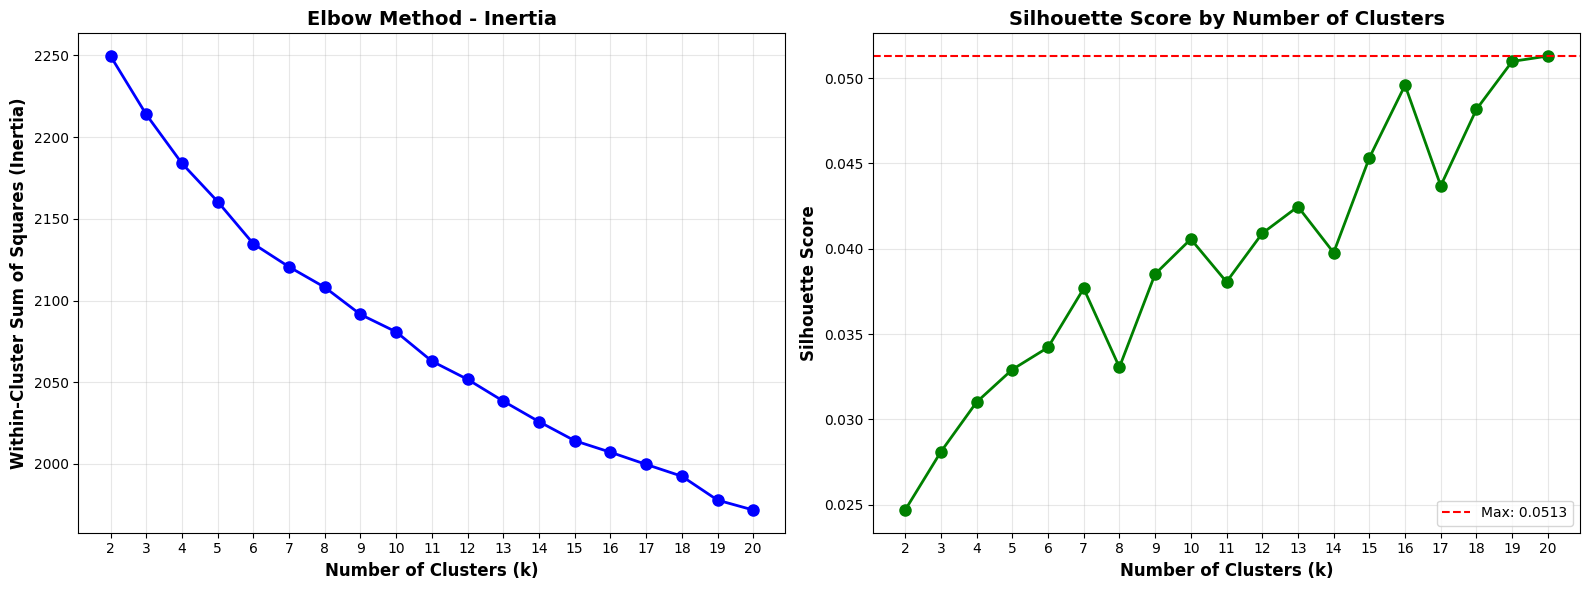


📊 Analysis:
----------------------------------------------------------------------
  • Look for 'elbow' in inertia plot (where rate of decrease slows)
  • Higher silhouette score indicates better-defined clusters
  • Optimal k by silhouette score: 20
  • We have 13 actual medical specialties in the data


In [4]:
print("\n" + "="*70)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

print("\nMethod 1: Elbow Method (Inertia)")
print("-"*70)
print("Testing k values from 2 to 20...")
print("This may take 3-5 minutes...\n")

# Test different k values
k_range = range(2, 21)
inertias = []
silhouette_scores = []

for k in k_range:
    print(f"Testing k={k}...", end=" ")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_tfidf)
    
    # Store metrics
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_tfidf, kmeans.labels_, sample_size=1000)
    silhouette_scores.append(sil_score)
    
    print(f"Inertia: {kmeans.inertia_:.2f}, Silhouette: {sil_score:.4f}")

print("\n✅ Cluster evaluation complete!")

# Plot Elbow Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow plot - Inertia
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette Score plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=max(silhouette_scores), color='r', linestyle='--', 
               label=f'Max: {max(silhouette_scores):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify optimal k
optimal_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]

print(f"\n📊 Analysis:")
print("-"*70)
print(f"  • Look for 'elbow' in inertia plot (where rate of decrease slows)")
print(f"  • Higher silhouette score indicates better-defined clusters")
print(f"  • Optimal k by silhouette score: {optimal_k_silhouette}")
print(f"  • We have 13 actual medical specialties in the data")

## Determine Optimal Number of Clusters - Elbow Method
<!-- Purpose: Find the best value of k (number of clusters)
Uses within-cluster sum of squares (inertia) -->

In [5]:
print("\n" + "="*70)
print("TRAINING FINAL K-MEANS MODEL")
print("="*70)

# Choose k value (can be adjusted based on elbow plot analysis)
chosen_k = 8  # Reasonable balance between detail and interpretability

print(f"\nSelected k = {chosen_k} clusters")
print("Rationale:")
print(f"  • Fewer than 13 actual specialties (for higher-level groupings)")
print(f"  • Allows discovery of document themes beyond specialty labels")
print(f"  • Balance between granularity and interpretability")

print(f"\nTraining K-Means with k={chosen_k}...")

# Train final K-Means model
final_kmeans = KMeans(
    n_clusters=chosen_k,
    random_state=42,
    n_init=20,              # More initializations for stability
    max_iter=500,           # More iterations for convergence
    verbose=0
)

# Fit model and get cluster assignments
cluster_labels = final_kmeans.fit_predict(X_tfidf)

print("✅ K-Means training complete!")

# Calculate clustering quality metrics
silhouette = silhouette_score(X_tfidf, cluster_labels, sample_size=1000)
calinski = calinski_harabasz_score(X_tfidf.toarray(), cluster_labels)
davies_bouldin = davies_bouldin_score(X_tfidf.toarray(), cluster_labels)

print(f"\nClustering Quality Metrics:")
print("-"*70)
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"    • Range: [-1, 1], Higher is better")
print(f"    • >0.5 = Good separation, 0.25-0.5 = Moderate, <0.25 = Poor")
print(f"  Calinski-Harabasz Score: {calinski:.2f}")
print(f"    • Higher is better (well-separated, dense clusters)")
print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
print(f"    • Lower is better (compact, well-separated clusters)")

# Add cluster labels to dataframe
all_df['cluster'] = cluster_labels


TRAINING FINAL K-MEANS MODEL

Selected k = 8 clusters
Rationale:
  • Fewer than 13 actual specialties (for higher-level groupings)
  • Allows discovery of document themes beyond specialty labels
  • Balance between granularity and interpretability

Training K-Means with k=8...
✅ K-Means training complete!

Clustering Quality Metrics:
----------------------------------------------------------------------
  Silhouette Score: 0.0324
    • Range: [-1, 1], Higher is better
    • >0.5 = Good separation, 0.25-0.5 = Moderate, <0.25 = Poor
  Calinski-Harabasz Score: 33.91
    • Higher is better (well-separated, dense clusters)
  Davies-Bouldin Score: 5.1465
    • Lower is better (compact, well-separated clusters)


## Select Final k and Train K-Means Model
<!-- Purpose: Train final clustering model with chosen k value
Balance between granularity and interpretability -->